In [1]:
import OCR_detection as ocr
import cv2 as cv
import random 
import numpy as np
import os
from matplotlib import pyplot as plt
from os import walk
import pandas as pd
def dsp(data, rows=10, columns=None):
    
    pd.options.display.max_rows = rows
    pd.options.display.max_columns = columns

    display(data)

    pd.options.display.max_rows = 15
    pd.options.display.max_columns = 20

In [2]:
def img_is_color(img):

    if len(img.shape) == 3:
        # Check the color channels to see if they're all the same.
        c1, c2, c3 = img[:, : , 0], img[:, :, 1], img[:, :, 2]
        if (c1 == c2).all() and (c2 == c3).all():
            return True

    return False

def show_image_list(list_images, list_titles=None, list_cmaps=None, grid=True, num_cols=2, figsize=(20, 10), title_fontsize=30):
    '''
    Shows a grid of images, where each image is a Numpy array. The images can be either
    RGB or grayscale.

    Parameters:
    ----------
    images: list
        List of the images to be displayed.
    list_titles: list or None
        Optional list of titles to be shown for each image.
    list_cmaps: list or None
        Optional list of cmap values for each image. If None, then cmap will be
        automatically inferred.
    grid: boolean
        If True, show a grid over each image
    num_cols: int
        Number of columns to show.
    figsize: tuple of width, height
        Value to be passed to pyplot.figure()
    title_fontsize: int
        Value to be passed to set_title().
    '''

    assert isinstance(list_images, list)
    assert len(list_images) > 0
    assert isinstance(list_images[0], np.ndarray)

    if list_titles is not None:
        assert isinstance(list_titles, list)
        assert len(list_images) == len(list_titles), '%d imgs != %d titles' % (len(list_images), len(list_titles))

    if list_cmaps is not None:
        assert isinstance(list_cmaps, list)
        assert len(list_images) == len(list_cmaps), '%d imgs != %d cmaps' % (len(list_images), len(list_cmaps))

    num_images  = len(list_images)
    num_cols    = min(num_images, num_cols)
    num_rows    = int(num_images / num_cols) + (1 if num_images % num_cols != 0 else 0)

    # Create a grid of subplots.
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    
    # Create list of axes for easy iteration.
    if isinstance(axes, np.ndarray):
        list_axes = list(axes.flat)
    else:
        list_axes = [axes]

    for i in range(num_images):

        img    = list_images[i]
        title  = list_titles[i] if list_titles is not None else 'Image %d' % (i)
        cmap   = list_cmaps[i] if list_cmaps is not None else (None if img_is_color(img) else 'gray')
        
        list_axes[i].imshow(img, cmap=cmap)
        list_axes[i].set_title(title, fontsize=title_fontsize) 
        list_axes[i].grid(grid)

    for i in range(num_images, len(list_axes)):
        list_axes[i].set_visible(False)

    fig.tight_layout()
    _ = plt.show()

In [9]:
folder = "C:/Users/LDE/Prog/OCR_detection/Tests_Analyse/numbers/img_number" 
numbers = ["0","1","2","3","4","5","6","7","8","9"]
columns = ["img", "number", "first","position", "posx","posy","width", "height"]


df = pd.DataFrame(columns = columns)

In [10]:
for number in numbers:
    filename = []
    for (dirpath, dirnames, filenames) in walk(folder + number):
        filename = [f for f in filenames if ".png" in f]
        break
        
    for f in filename:
        img = cv.rotate
        img = cv.rotate(cv.imread(folder + number + "/" + f), cv.ROTATE_180)
        rectangles,imgs_cropped, img_resized, imgs_th, POIs_total_th, POIs_total_img_resized, POIs_total_img = ocr.find_numbers_positions(img)
        for i,(key,poi) in enumerate(POIs_total_img_resized.items()):
            
            x,y,w,h = rectangles[key]
            first = f.split("_")[1].split(".")[0]
            first = True if first == "True" else False
            d = {"img":[poi],"number" : number, "first" : first,"position" : i, "posx" : x,"posy":y,"width":w,"height": h}
            new_row = pd.Series(data = d, index = columns)
            df = pd.concat([df,new_row.to_frame().T],ignore_index = True)
            

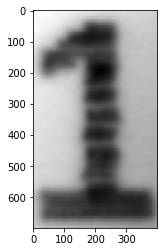

In [21]:
query = df[((df.number == "1")  & (df["first"] == True))]
#dsp(query)
img_0 = []
hist_poi_mean = []

img_shape = (400,700)
nbr_image = 0
shape_mean = np.zeros((img_shape[1],img_shape[0]))

for i,(index, row) in enumerate(query.iterrows()):
    
    poi = row["img"][0]
    poi_resized = cv.resize(poi, img_shape, interpolation = cv.INTER_AREA)
    
    poi_th = cv.adaptiveThreshold(poi_resized,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,51,10)
    poi_th_blurred = cv.GaussianBlur(poi_th,(1,5),0)
    _,poi_th_blurred_th = cv.threshold(poi_th_blurred,240,255,cv.THRESH_BINARY)
    
    
    equ = cv.equalizeHist(poi_resized)
    equ_th = cv.adaptiveThreshold(equ,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,13,2)
    equ_th_masked = np.ma.masked_array(equ_th, mask=poi_th_blurred_th)
    
    """"
    fig, ax = plt.subplots(1,6,figsize = (15,4))
    
    ax[0].imshow(poi,'gray')
    ax[1].imshow(poi_th_blurred_th,'gray')
    ax[2].imshow(poi_resized,'gray')
    ax[3].imshow(equ,'gray')
    ax[4].imshow(equ_th_masked,'gray')
    ax[5].text(0,0.5,str(d1))
    
    #print(np.shape(shape_mean), np.shape(poi_resized))
    """
    shape_mean += poi_resized
    
    
shape_mean /= i+1
shape_mean = shape_mean.astype('uint8')
plt.imshow(shape_mean,'gray')
plt.show()

(2,)
0.0


C:\Users\LDE\AppData\Roaming\Python\Python38\site-packages\numpy\core\fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


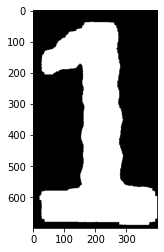

In [22]:
_, shape_mean_th = cv.threshold(shape_mean,90,255,cv.THRESH_BINARY)

shape_mean_th_not = np.abs(shape_mean_th - 255)
contours,hierarchy = cv.findContours(shape_mean_th_not,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
ret11 = cv.matchShapes(contours[0],contours[0],1,0.0)

print(np.shape(contours))
print(ret11)

plt.imshow(shape_mean_th_not,'gray')
plt.show()

<ipython-input-26-c4814f81ec6d>:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,6,figsize = (15,4))


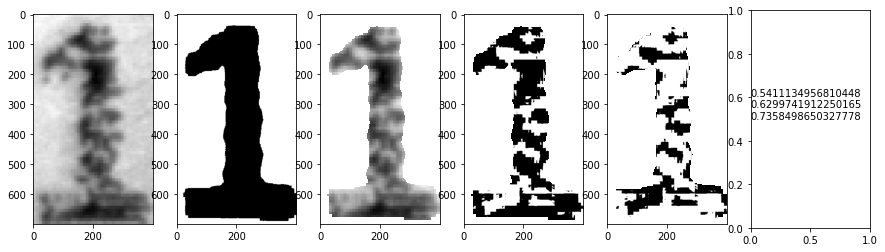

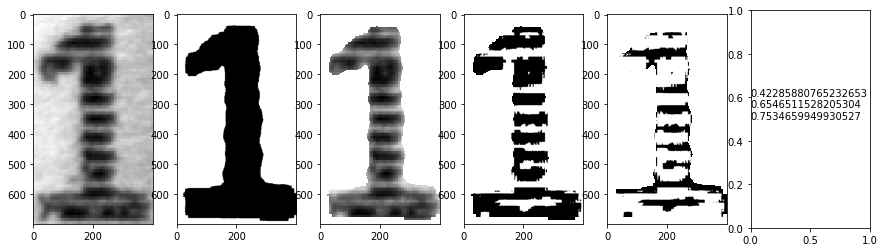

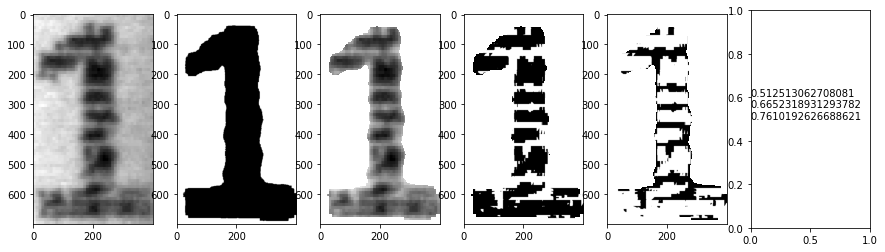

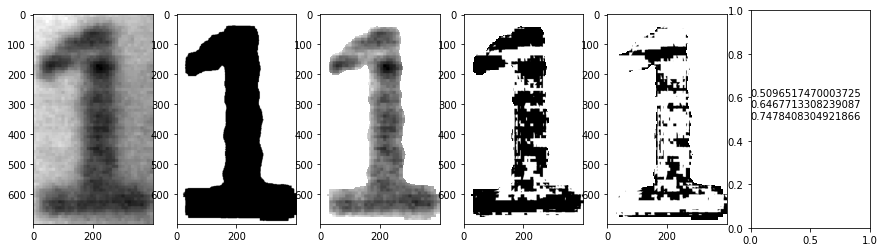

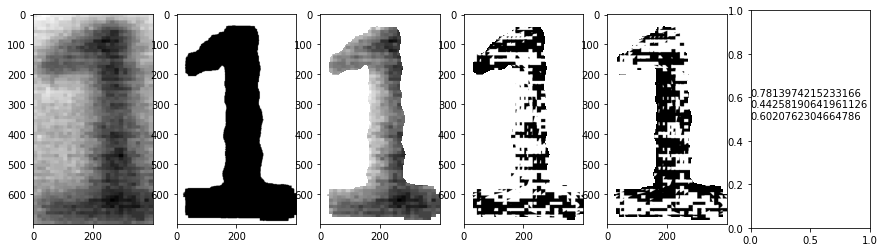

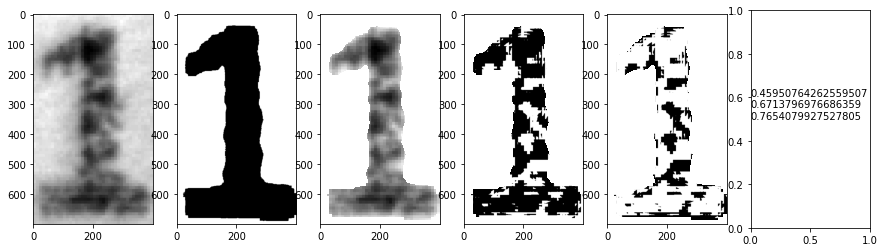

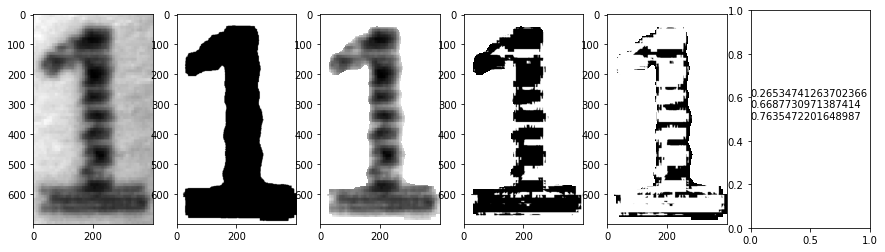

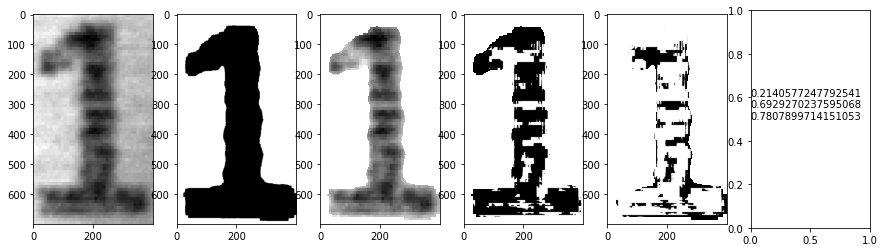

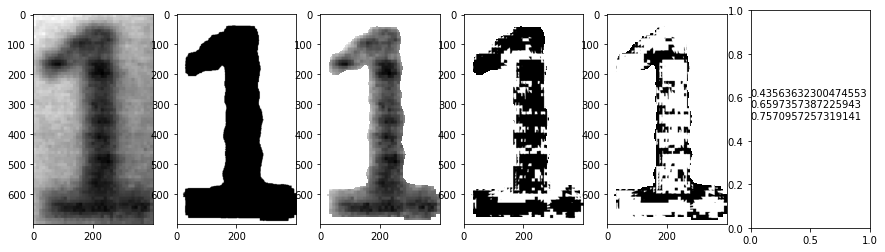

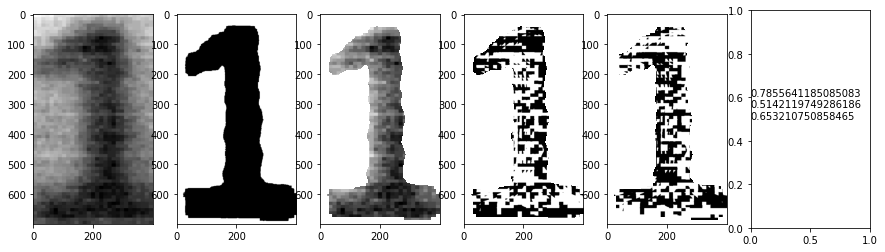

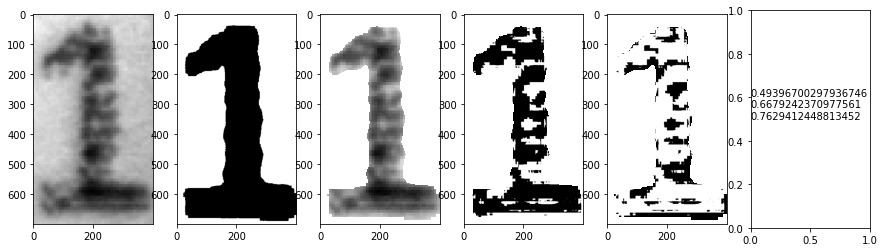

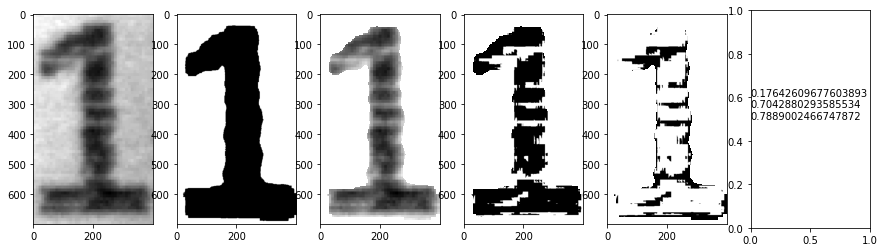

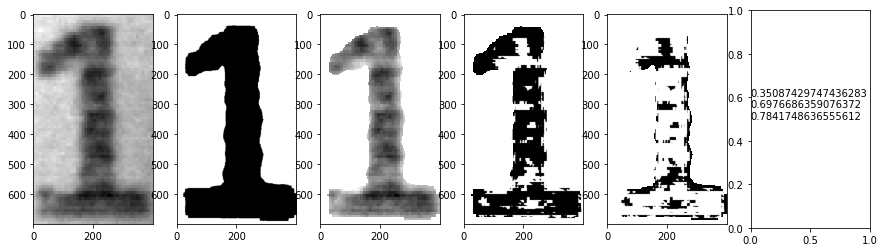

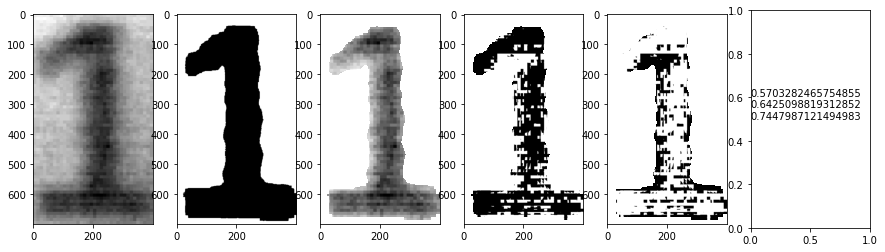

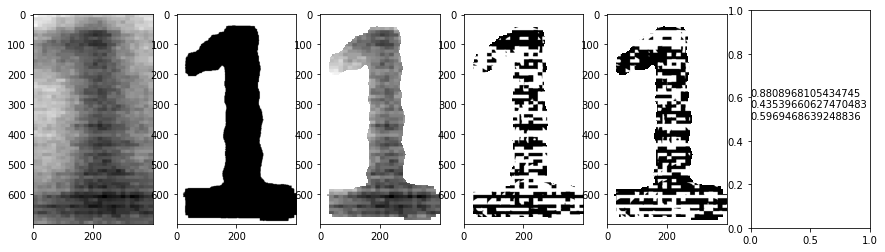

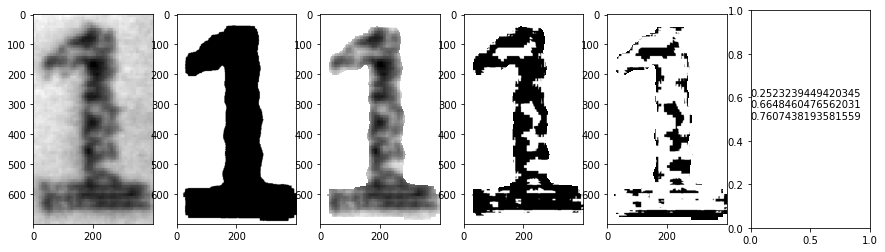

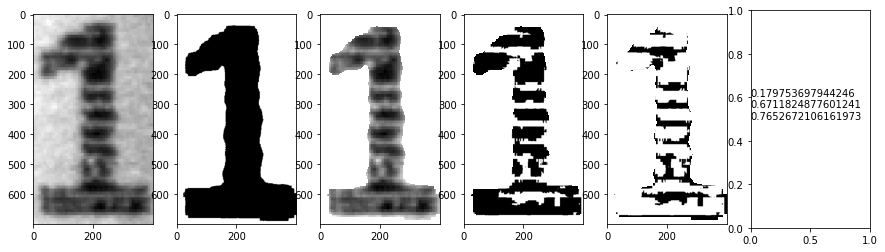

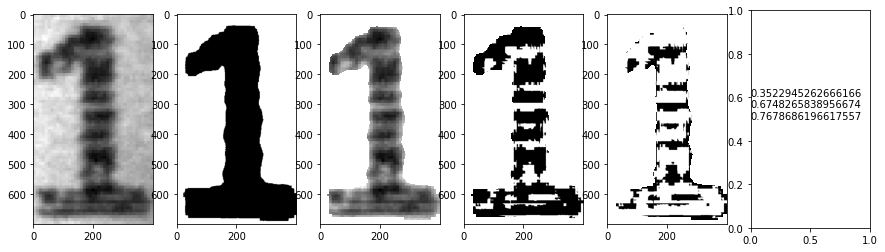

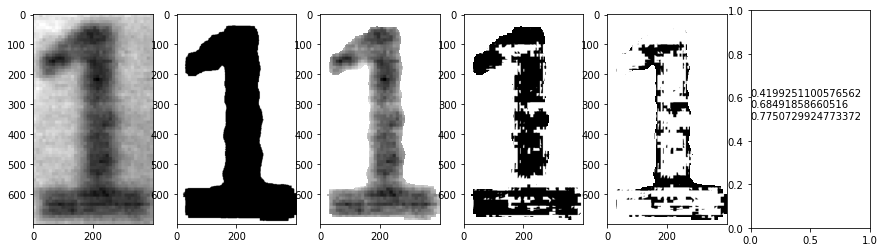

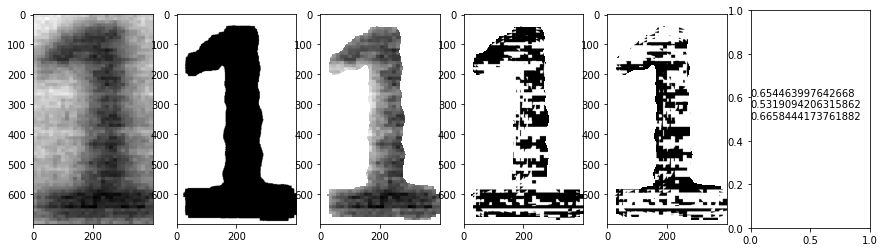

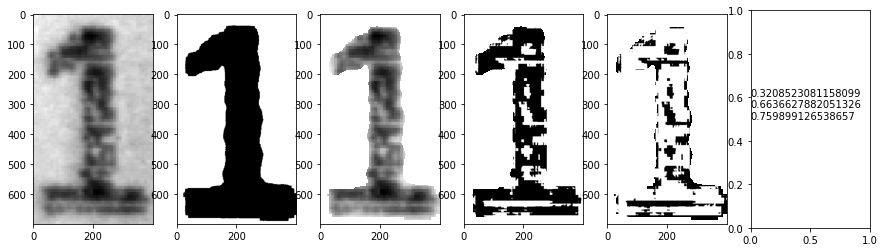

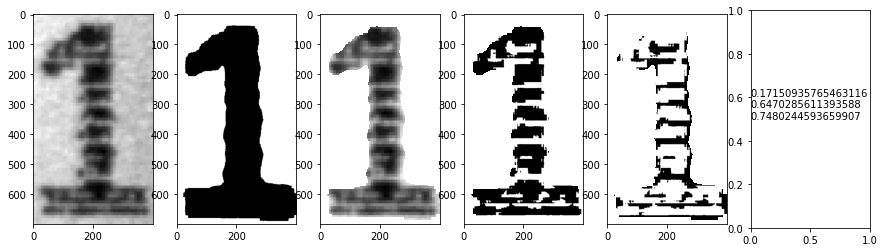

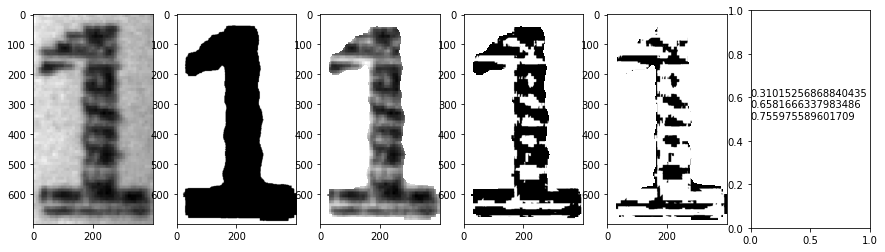

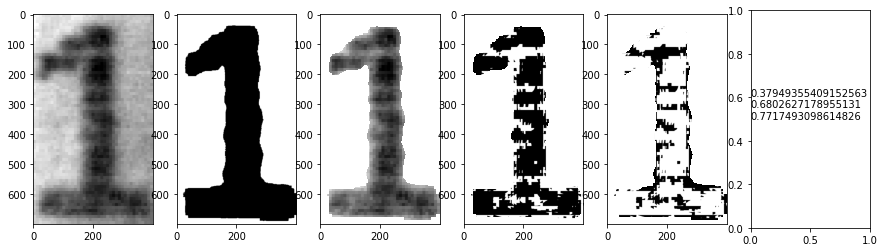

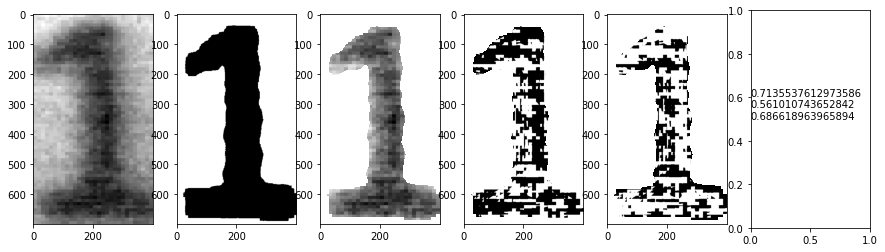

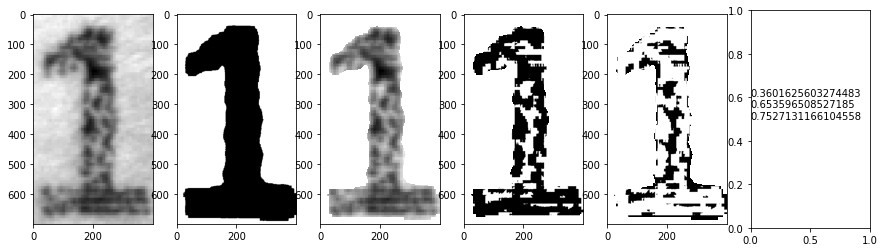

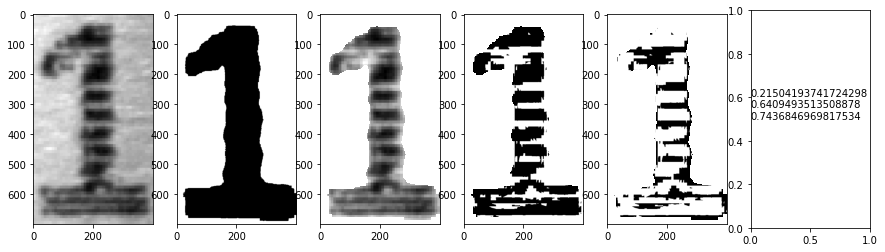

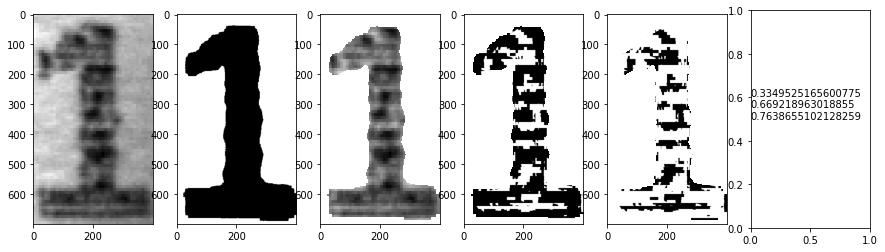

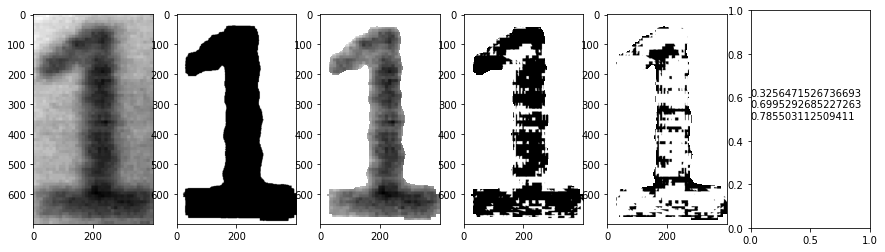

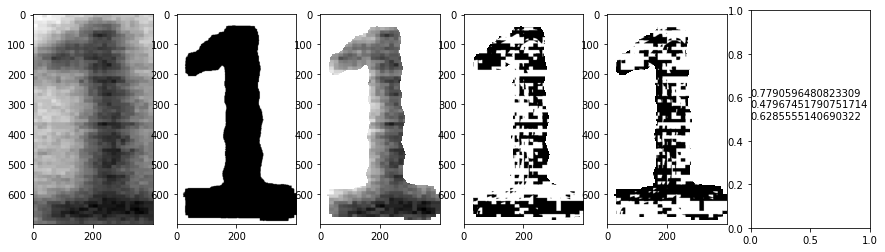

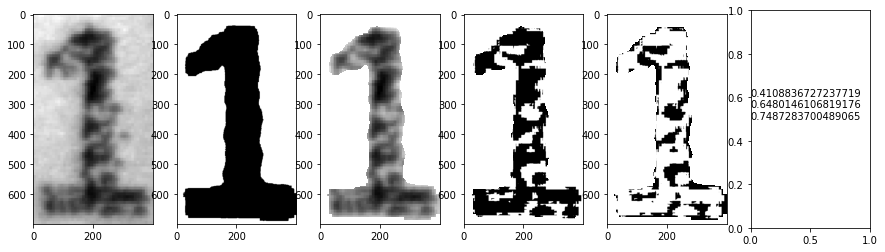

In [26]:
for i,(index, row) in enumerate(query.iterrows()):
    
    poi = row["img"][0]
    poi_resized = cv.resize(poi, img_shape, interpolation = cv.INTER_AREA)
    
    poi_th = cv.adaptiveThreshold(poi_resized,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,51,10)
    poi_th_blurred = cv.GaussianBlur(poi_th,(1,5),0)
    _,poi_th_blurred_th = cv.threshold(poi_th_blurred,240,255,cv.THRESH_BINARY)
    
    
    equ = cv.equalizeHist(poi_resized)
    equ_masked = np.ma.masked_array(poi_resized, mask=shape_mean_th)
    equ_masked_th = cv.adaptiveThreshold(equ_masked,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,101,2)
    equ_masked_th = np.ma.masked_array(equ_masked_th, mask=shape_mean_th)
    #_,equ_masked_th = cv.threshold(equ_masked,10,255,cv.THRESH_BINARY)
    
    hist_poi = cv.calcHist([poi_th_blurred_th],[0],None,[256],[0,256]) 
    hist_equ = cv.calcHist([equ_th_masked],[0],None,[256],[0,256]) 
    
    # Calculate Moment
    moments_ref = cv.moments(poi_th_blurred_th)
    moments_prob = cv.moments(equ_th_masked)
    # Calculate Hu Moments
    huMoments_ref = cv.HuMoments(moments_ref)
    huMoments_prob = cv.HuMoments(moments_prob)
    
   
    prob_th_not = np.abs(equ_masked_th - 255)
    #contours_prob,hierarchy_prob = cv.findContours(prob_th_not,cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    

    
    d  = cv.matchShapes(equ_masked_th,shape_mean_th,1,0.0)*100
    d1 = len(equ_masked_th[equ_masked_th == 0]) / len(shape_mean_th[shape_mean_th == 0])
    d2 = 1-np.sum(equ_masked_th)/np.sum(shape_mean_th)
    
    hist_poi_mean.append(hist_poi[0])
    
    fig, ax = plt.subplots(1,6,figsize = (15,4))
    
    ax[0].imshow(poi_resized,'gray')
    ax[1].imshow(shape_mean_th,'gray')
    ax[2].imshow(equ_masked,'gray')
    ax[3].imshow(equ_masked_th,'gray')
    ax[4].imshow(prob_th_not,'gray')
    ax[5].text(0,0.5,str(d)+"\n"+ str(d1) + "\n" + str(d2))
    
    #print(np.shape(shape_mean), np.shape(poi_resized))
    if i == 30:
        break
    